In [5]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter, savgol_coeffs
from scipy.optimize import curve_fit

import math

import json

## General Tool Functions

In [2]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)

In [3]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor < 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5, polyorder=3):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = polyorder
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10, D2=None):
    Q = np.ascontiguousarray(Q_train, dtype=np.float64)
    y = np.ascontiguousarray(y_train, dtype=np.float64)
    n = Q.shape[0]

    # Reuse distances if provided
    if D2 is None:
        # Pre-scale once to save a division in the exponent
        X = Q / length
        D2 = (X[:, None] - X[None, :])**2          # = (Q_i-Q_j)^2 / length^2
        K = s2 * np.exp(-0.5 * D2)
    else:
        K = s2 * np.exp(-0.5 * D2 / (length*length))

    # Fast diag add, scalar/vector unified
    if np.isscalar(noise_var):
        K.ravel()[::n+1] += (noise_var + jitter)
        nv = noise_var
    else:
        nv = np.ascontiguousarray(noise_var, dtype=y.dtype)
        K.ravel()[::n+1] += nv + jitter

    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    mu = y - (nv * z if not np.isscalar(nv) else nv * z)
    return mu

import numpy as np

# ---------- RBF helpers ----------
def _rbf_col(X, i, length, s2=1.0):
    """Return the i-th kernel column k(:, i) for RBF without forming K."""
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        diff2 = (X - X[i])**2
    else:
        diff = X - X[i]
        diff2 = np.sum(diff*diff, axis=1)
    inv_l2 = 0.5 / (length*length)   # = 1/(2 ℓ^2)
    return s2 * np.exp(-inv_l2 * diff2)

# ---------- Pivoted Cholesky factor (K ≈ U U^T) ----------
def pivoted_cholesky_rbf(X, length, s2=1.0, max_rank=256, tol=1e-10):
    """
    Build low-rank factor U (n×r) s.t. K ≈ U U^T for RBF kernel.
    K_ij = s2 * exp(-||x_i - x_j||^2 / (2 ℓ^2)).
    diag(K) = s2 (constant), so initial residual diag = s2 * ones.

    Returns
    -------
    U : (n, r) array
    pivots : (r,) pivot indices used
    resid_diag : (n,) final residual diagonal (K - U U^T)_ii
    """
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    rmax = min(max_rank, n)

    U = np.zeros((n, rmax), dtype=np.float64)
    resid = np.full(n, float(s2))         # residual diag
    pivots = np.empty(rmax, dtype=int)

    used = np.zeros(n, dtype=bool)
    for r in range(rmax):
        i = int(np.argmax(resid))
        piv = resid[i]
        if piv <= tol:
            # truncate
            U = U[:, :r]
            pivots = pivots[:r]
            break
        pivots[r] = i
        used[i] = True

        # c = k(:, i) - sum_{t<r} U[:,t] * U[i,t]
        col = _rbf_col(X, i, length, s2=s2)
        if r > 0:
            proj = U[:, :r] @ U[i, :r]
            col = col - proj

        U[:, r] = col / np.sqrt(piv)
        # update residual diag: resid -= u_r^2
        resid -= U[:, r]**2
        # numerical guard
        np.maximum(resid, 0.0, out=resid)

    else:
        # filled rmax
        pivots = pivots[:rmax]

    return U, pivots, resid

# ---------- Woodbury solver for (D + U U^T) z = y ----------
def woodbury_solve(U, D, y):
    """
    Solve (D + U U^T) z = y with D diagonal (vector of length n).
    Uses: z = D^{-1} y - D^{-1} U (I + U^T D^{-1} U)^{-1} U^T D^{-1} y
    """
    U = np.asarray(U, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    invD = 1.0 / D

    # Compute small system A = I + U^T D^{-1} U  (m x m)
    # and rhs b = U^T D^{-1} y
    UDinv = U * invD[:, None]        # n×m
    A = np.eye(U.shape[1], dtype=np.float64) + (U.T @ UDinv)
    b = U.T @ (invD * y)

    # Solve A w = b (SPD => Cholesky)
    L = np.linalg.cholesky(A)
    w = np.linalg.solve(L, b)
    w = np.linalg.solve(L.T, w)

    # Back to z
    z = invD * y - (invD[:, None] * U) @ w
    return z

# ---------- High-level: posterior mean at training points ----------
def gpr_posterior_mean_lowrank(X, y, noise_var, length, s2=1.0, jitter=1e-10,
                               max_rank=256, tol=1e-10, U_precomputed=None):
    """
    Compute μ = y - Σ (K+Σ)^{-1} y using a low-rank K ≈ U U^T (pivoted Cholesky) and Woodbury.

    Parameters
    ----------
    X : (n,d) or (n,) array of inputs
    y : (n,) array
    noise_var : float or (n,) array   (Σ diagonal entries)
    length : float (RBF ℓ)
    s2 : float (signal variance)
    jitter : float, added to the *solver* diagonal only (not to Σ in μ = y - Σ z)
    max_rank : int, target rank
    tol : float, pivot stopping tolerance on residual diagonal
    U_precomputed : optional (n,r) factor to reuse; if provided, skips factorization

    Returns
    -------
    mu : (n,) posterior mean at training points
    U : (n,r) low-rank factor (for reuse across multiple y)
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    n = X.shape[0]

    if U_precomputed is None:
        U, piv, resid = pivoted_cholesky_rbf(X, length, s2=s2, max_rank=max_rank, tol=tol)
    else:
        U = np.asarray(U_precomputed, dtype=np.float64)

    # Build diagonal D = Σ + jitter
    if np.isscalar(noise_var):
        D = np.full(n, noise_var + jitter, dtype=np.float64)
        Sigma = noise_var
    else:
        nv = np.asarray(noise_var, dtype=np.float64)
        D = nv + jitter
        Sigma = nv  # used elementwise below

    # Solve (K+Σ+jitter I) z = y with low-rank K via Woodbury
    z = woodbury_solve(U, D, y)

    # μ = y - Σ z  (IMPORTANT: use Σ only, not Σ+jitter)
    if np.isscalar(Sigma):
        mu = y - Sigma * z
    else:
        mu = y - Sigma * z
    return mu

# gpr_posterior_mean = gpr_posterior_mean_lowrank  # alias

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

In [4]:
def calculate_slope_integral(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_slope_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=1
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=1, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_prime = D @ I
    I_prime_sq = I_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def calculate_curvature_integral(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I
    
    # Use Savitzky-Golay filter to get the second derivative of intensity with respect to Q
    smoothed_I_double_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=2, delta=np.mean(np.diff(Q_best)))
    
    # Square the second derivative.
    I_double_prime_squared = smoothed_I_double_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    
    return integral_val

def calculate_curvature_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=2
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=2, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_double_prime = D @ I
    I_double_prime_sq = I_double_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_double_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_double_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def f_beta(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the beta parameter 
    """
    beta = calculate_slope_integral(data, window_length, polyorder) / (12.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_slope_integral_with_uncertainty(data, window_length, polyorder)
        beta, beta_std = integral / (12.0 * (data.Q.max() - data.Q.min())), integral_std / (12.0 * (data.Q.max() - data.Q.min()))
        return beta, beta_std
    return beta

def f_gamma(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the gamma parameter 
    """
    gamma = calculate_curvature_integral(data, window_length, polyorder) / (4.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_curvature_integral_with_uncertainty(data, window_length, polyorder)
        gamma, gamma_std = integral / (4.0 * (data.Q.max() - data.Q.min())), integral_std / (4.0 * (data.Q.max() - data.Q.min()))
        return gamma, gamma_std
    return gamma

def f_alpha(data, total_counts):
    """
    Calculate the A0 parameter 
    """
    L = data.Q.max() - data.Q.min()
    mean_I = np.mean(data.I)
    return L * (mean_I ** 2)/ total_counts

## D22

Possible bin sizes (x): []
Possible collimations (y): []
Possible collection times (z): []
39
597
77
1191
151
300


Text(0, 0.5, 'Intensity ($\\mathrm{cm}^{-1}$)')

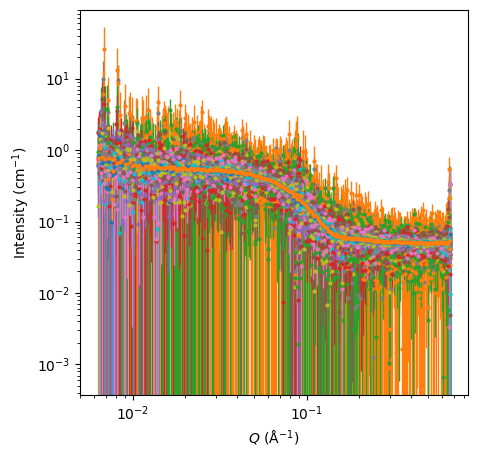

In [5]:
# Step 0: Display the data labels
data_dir = '../data/'
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

bin_sizes = set()
collimations = set()
collection_times = set()

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        bin_sizes.add(x)
        collimations.add(y)

        folder_path = os.path.join(data_dir, folder)
        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 == z2:
                    # Strip leading zeros
                    collection_times.add(z1.lstrip('0') or '0')
                else:
                    print(f"Inconsistent collection time in file: {fname}")

print("Possible bin sizes (x):", sorted(bin_sizes))
print("Possible collimations (y):", sorted(collimations))
print("Possible collection times (z):", sorted(collection_times))

time_list = [1,3,10,30,100,300,1000]

# Step 1: Load Data

data_dir = './data/'
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]

folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f.startswith('G5_res_')]

for folder in folders:
    parts = folder.split('_')
    if len(parts) >= 4:
        x = parts[2]  # bin size
        y = parts[3].removesuffix('C')  # collimation
        folder_path = os.path.join(data_dir, folder)

        for fname in os.listdir(folder_path):
            match = re.match(r'^\d+_d(\d+)_c(\d+)\.dat$', fname)
            if match:
                z1, z2 = match.group(1), match.group(2)
                if z1 != z2:
                    print(f"Mismatch in collection time in file: {fname}")
                    continue
                z = z1.lstrip('0') or '0'

                fpath = os.path.join(folder_path, fname)
                with open(fpath, 'r') as f:
                    lines = f.readlines()

                # Extract Total Det Counts from line 41 (index 40)
                try:
                    total_counts_line = lines[40]
                    total_counts = int(re.search(r'Total Det Counts:\s*(\d+)', total_counts_line).group(1))
                except Exception as e:
                    print(f"Could not extract Total Det Counts from {fname}: {e}")
                    total_counts = None

                # Find index of the data block
                for i, line in enumerate(lines):
                    if line.strip().startswith('Mod_Q'):
                        data_lines = lines[i+1:]
                        break
                else:
                    print(f"No data block found in {fname}")
                    continue

                # Load numerical data
                try:
                    array = np.loadtxt(data_lines)
                    if array.ndim == 1:
                        array = array[np.newaxis, :]  # handle single-row case
                    Q, I, I_err, dQ = array.T
                    
                    ###### this is where we create the ScatteringData object ######
                    data[x][y][z] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)
                except Exception as e:
                    print(f"Error loading {fname}: {e}")     

# Step 3: Preview Data
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '17'
for i_bin, bin_size_key in enumerate(sorted(data.keys())):
    for i_time, time_key in enumerate(sorted(data[bin_size_key][collimation].keys())):
        scattering_data = data[bin_size_key][collimation][time_key]
        Q = scattering_data.Q
        I = scattering_data.I
        I_err = scattering_data.I_err
        dQ = scattering_data.dQ
        total_counts = scattering_data.total_counts
        
        # print(total_counts)

        ax.errorbar(Q, I, yerr=I_err, label=f'Bin: {bin_size_key}, Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))
        
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity ($\mathrm{cm}^{-1}$)')


Using best dataset: Bin size = 4, Time = 7
Using nbins = 304 for synthetic data generation
Using nbins = 304 for synthetic data generation
Using nbins = 304 for synthetic data generation
Using nbins = 304 for synthetic data generation
bin width: 0.0016071038815789473


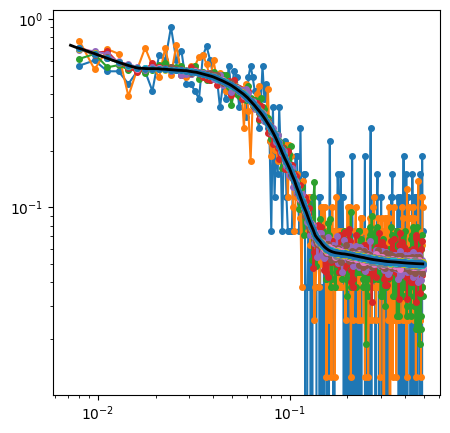

In [6]:
# Select a collimation to analyze
fixed_collimation = '17' # manually selected

best_bin_size_str = '4'  # manually selected
best_time_str = '7'
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 7e-3
Q_max_range = 5e-1

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 30
polyorder = 2

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'D22'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = int(L/0.025)*16  # aim for ~0.025 1/Angstrom bin width
    print(f"Using nbins = {nbins} for synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'D22' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [7]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['D22'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 4.0852e-02
beta  = 1.6934e-01 ± 4.5244e-04
gamma = 3.8690e+02 ± 3.8492e+00
h_instr = 1.6018e-03
time = 1000.0, h_FD = 4.9409e-02, lambda_opt = 2.3680e-02
time = 3000.0, h_FD = 3.4258e-02, lambda_opt = 1.9009e-02
time = 10000.0, h_FD = 2.2934e-02, lambda_opt = 1.4941e-02
time = 30000.0, h_FD = 1.5901e-02, lambda_opt = 1.1994e-02
time = 100000.0, h_FD = 1.0645e-02, lambda_opt = 9.4274e-03
time = 300000.0, h_FD = 7.3807e-03, lambda_opt = 7.5677e-03
time = 1000000.0, h_FD = 4.9409e-03, lambda_opt = 5.9483e-03
time = 3000000.0, h_FD = 3.4258e-03, lambda_opt = 4.7749e-03
time = 10000000.0, h_FD = 2.2934e-03, lambda_opt = 3.7531e-03
time = 30000000.0, h_FD = 1.5901e-03, lambda_opt = 3.0128e-03
time = 100000000.0, h_FD = 1.0645e-03, lambda_opt = 2.3680e-03


/tmp/ipykernel_120206/2176783573.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_D22.json


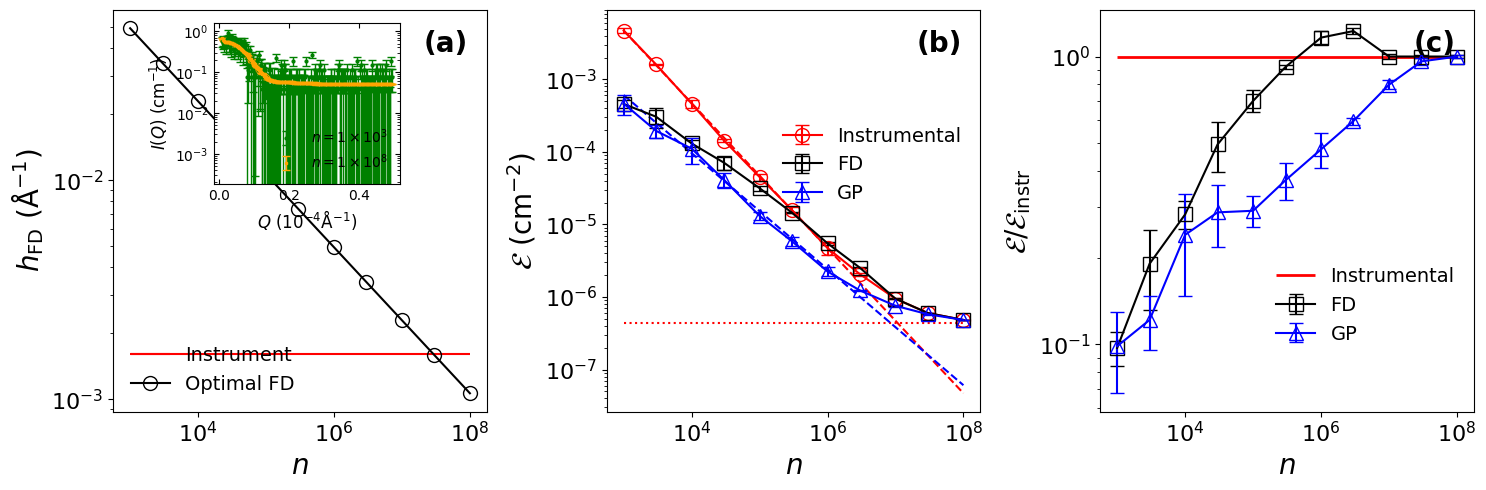

In [8]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_D22.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## HANARO

['../data/hanaro_Apr1/APR01031.ABS', '../data/hanaro_Apr1/APR01032.ABS', '../data/hanaro_Apr1/APR01033.ABS', '../data/hanaro_Apr1/APR01034.ABS', '../data/hanaro_Apr1/APR01035.ABS', '../data/hanaro_Apr1/APR01036.ABS', '../data/hanaro_Apr1/APR01037.ABS', '../data/hanaro_Apr1/APR01038.ABS']
173
173
173
173
173
173
173
173
count per sec: 16.67031758106049
average bin size: 0.00021469364161849711


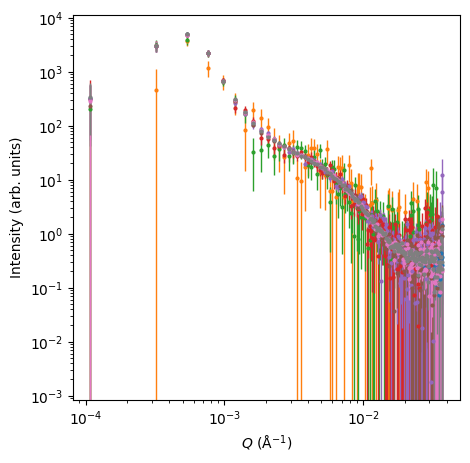

In [9]:
file_path = '../data/hanaro_Apr1/'
filenames = [f"APR{str(i).zfill(5)}.ABS" for i in range(1031, 1039)]
files = [os.path.join(file_path, fname) for fname in filenames]
print(files)

data_list = []
time_list = []
# Read data from files
for file in files:
    data = np.loadtxt(file, skiprows=14)
    # Extract collection time from filename using regex
    # Example filename: Apr01031.0058321.txt -> collection time is the number after the dot
    # Extract collection time from file by reading the header
    collection_time = None
    with open(file, 'r') as f:
        for _ in range(14):  # Read header lines
            line = f.readline()
            match = re.search(r'LABEL:.*?(\d+)s', line)
            if match:
                collection_time = int(match.group(1))
                break
    data_list.append(data)
    time_list.append(collection_time)
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
# ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))
print('average bin size: {}'.format((np.max(Q) - np.min(Q)) / len(Q)))
delta_Q_ave = (np.max(Q) - np.min(Q)) / len(Q)

Using best dataset: Bin size = EQSANS, Time = 10000
Using nbins = 256 for synthetic data generation
Using nbins = 256 for synthetic data generation
Using nbins = 256 for synthetic data generation
Using nbins = 256 for synthetic data generation
bin width: 6.749609375000001e-05


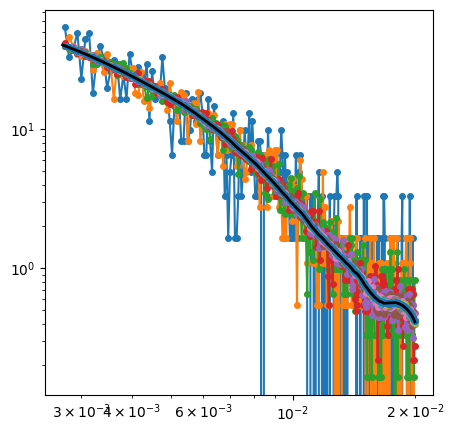

In [10]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 2.5e-3
Q_max_range = 2e-2

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 21
polyorder = 3

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'D22'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 256
    print(f"Using nbins = {nbins} for synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'D22' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [11]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['D22'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 7.5316e-01
beta  = 1.4099e+06 ± 1.5072e+04
gamma = 2.5534e+12 ± 2.2096e+10
h_instr = 6.7232e-05
time = 1000.0, h_FD = 6.4400e-04, lambda_opt = 4.6091e-04
time = 3000.0, h_FD = 4.4653e-04, lambda_opt = 3.6999e-04
time = 10000.0, h_FD = 2.9892e-04, lambda_opt = 2.9082e-04
time = 30000.0, h_FD = 2.0726e-04, lambda_opt = 2.3345e-04
time = 100000.0, h_FD = 1.3875e-04, lambda_opt = 1.8349e-04
time = 300000.0, h_FD = 9.6201e-05, lambda_opt = 1.4730e-04
time = 1000000.0, h_FD = 6.4400e-05, lambda_opt = 1.1578e-04
time = 3000000.0, h_FD = 4.4653e-05, lambda_opt = 9.2939e-05
time = 10000000.0, h_FD = 2.9892e-05, lambda_opt = 7.3050e-05
time = 30000000.0, h_FD = 2.0726e-05, lambda_opt = 5.8640e-05
time = 100000000.0, h_FD = 1.3875e-05, lambda_opt = 4.6091e-05


/tmp/ipykernel_120206/646722045.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_HANARO.json


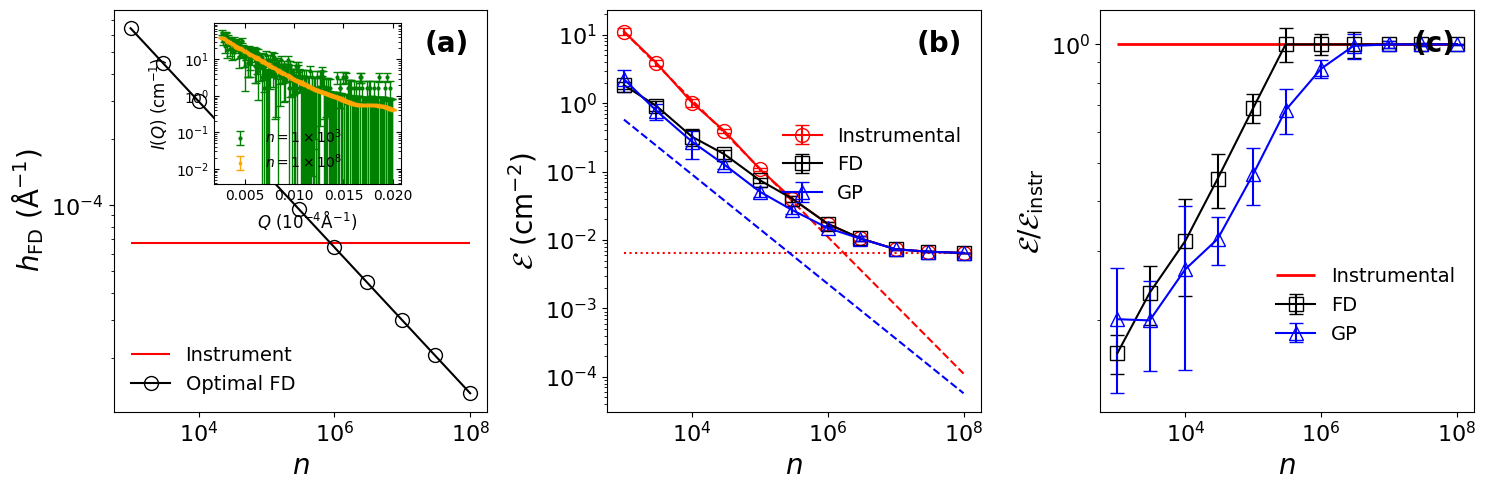

In [12]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_HANARO.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## USANS

measure_time,undefined,1e4,3e4,1e5,3e5,3e6
samples,,,,,,
sample1,UN_Sample1_det_1_unscaled.txt,UN_Sample1_1e4_det_1_unscaled.txt,UN_Sample1_3e4_det_1_unscaled.txt,UN_Sample1_1e5_det_1_unscaled.txt,UN_Sample1_3e5_det_1_unscaled.txt,NaN
sample2,UN_Sample2_det_1_unscaled.txt,UN_Sample2_1e4_det_1_unscaled.txt,UN_Sample2_3e4_det_1_unscaled.txt,UN_Sample2_1e5_det_1_unscaled.txt,UN_Sample2_3e5_det_1_unscaled.txt,NaN
sample3,UN_Sample3_det_1_unscaled.txt,UN_Sample3_1e4_det_1_unscaled.txt,UN_Sample3_3e4_det_1_unscaled.txt,UN_Sample3_1e5_det_1_unscaled.txt,UN_sample3_3e5_det_1_unscaled.txt,UN_Sample3_3e6_det_1_unscaled.txt
sample4,UN_Sample4_det_1_unscaled.txt,UN_Sample4_1e4_det_1_unscaled.txt,UN_Sample4_3e4_det_1_unscaled.txt,UN_Sample4_1e5_det_1_unscaled.txt,UN_Sample4_3e5_det_1_unscaled.txt,UN_Sample4_3e6_det_1_unscaled.txt
sample5,UN_Sample5_det_1_unscaled.txt,UN_Sample5_1e4_det_1_unscaled.txt,UN_Sample5_3e4_det_1_unscaled.txt,UN_Sample5_1e5_det_1_unscaled.txt,UN_Sample5_3e5_det_1_unscaled.txt,NaN
sample6,UN_Sample6_det_1_unscaled.txt,UN_Sample6_1e4_det_1_unscaled.txt,UN_Sample6_3e4_det_1_unscaled.txt,NaN,UN_Sample6_3e5_det_1_unscaled.txt,NaN
sample7,UN_Sample7_det_1_unscaled.txt,UN_Sample7_1e4_det_1_unscaled.txt,UN_Sample7_3e4_det_1_unscaled.txt,UN_Sample7_1e5_det_1_unscaled.txt,UN_Sample7_3e5_det_1_unscaled.txt,NaN
sample8,UN_Sample8_det_1_unscaled.txt,UN_Sample8_1e4_det_1_unscaled.txt,UN_Sample8_3e4_det_1_unscaled.txt,UN_Sample8_1e5_det_1_unscaled.txt,UN_Sample8_3e5_det_1_unscaled.txt,NaN
sample9,UN_Sample9_det_1_unscaled.txt,UN_Sample9_1e4_det_1_unscaled.txt,UN_Sample9_3e4_det_1_unscaled.txt,UN_Sample9_1e5_det_1_unscaled.txt,UN_sample9_3e5_det_1_unscaled.txt,NaN


64
64
64
64
64
64


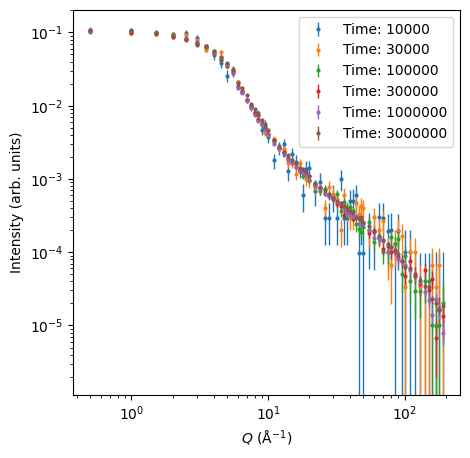

In [13]:
import os
import pandas as pd
import re

file_path = "../data/USANS/32871/"
sample_files = [f for f in os.listdir(file_path) if 'sample' in f.lower()]
labels = ["unscaled", "lb", "lbs"]
filtered_files = [f for f in sample_files if labels[0] in f]
# Prepare lists to store extracted info
measure_times = []
samples = []

for fname in filtered_files:
    # Extract measure time (e.g., 1e4, 3e5, etc.)
    match_time = re.search(r'_(\d+e\d+)_', fname)
    measure_times.append(match_time.group(1) if match_time else None)
    # Extract samples (e.g., Sample1, Sample2, etc.)
    match_samples = re.search(r'(Sample\d+)', fname, re.IGNORECASE)
    samples.append(match_samples.group(1) if match_samples else None)

# Create DataFrame
df_info = pd.DataFrame({
    'filename': filtered_files,
    'measure_time': measure_times,
    'samples': samples
})

# Normalize sample names to lowercase for merging
df_info['samples'] = df_info['samples'].str.lower()
df_info['measure_time'] = df_info['measure_time'].fillna('undefined')
df_pivot = df_info.pivot_table(index='samples', columns='measure_time', values='filename', aggfunc='first')

# Sort columns by measurement time, keeping 'undefined' first
def time_key(x):
    if x == 'undefined':
        return -float('inf')
    try:
        return float(x.replace('e', 'E'))
    except:
        return float('inf')

sorted_columns = sorted(df_pivot.columns, key=time_key)
df_pivot = df_pivot.reindex(columns=sorted_columns)

display(df_pivot)

sample4_files = df_info[df_info['samples'].str.lower() == 'sample4']['filename']
sample4_data_list = [
    np.loadtxt(os.path.join(file_path, fname), skiprows=0, delimiter=',', usecols=(0,1,2))
    for fname in sample4_files
]

sample4_time_list = []
for fname in sample4_files:
    match = re.search(r'_(\d+e\d+)_', fname)
    if match:
        sample4_time_list.append(float(match.group(1)))
    else:
        sample4_time_list.append(np.nan)

sample4_time_list = [1e6 if np.isnan(t) else t for t in sample4_time_list]

# Combine times and data, sort by time, then unpack
sorted_items = sorted(zip(sample4_time_list, sample4_data_list), key=lambda x: (np.isnan(x[0]), x[0]))
sample4_time_list_sorted, sample4_data_list_sorted = zip(*sorted_items)

# Convert back to list
sample4_time_list = list(sample4_time_list_sorted)
sample4_data_list = list(sample4_data_list_sorted)

data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For USANS, we use bin='USANS' and collimation='-', time is represented by total counts

# Store Sample4 data into the data structure using measurement time as key
for i, arr in enumerate(sample4_data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = np.zeros_like(Q)  # USANS files may not have dQ; set to zeros or estimate if available
    total_counts = sample4_time_list[i]
    # Use bin='USANS', collimation='-', time=str(int(total_counts))
    data['USANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # USANS uses '-' for collimation
sorted_time_keys = sorted(data['USANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['USANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

Using best dataset: Bin size = USANS, Time = 3000000
Using nbins = 192 for synthetic data generation
Using nbins = 192 for synthetic data generation
Using nbins = 192 for synthetic data generation
Using nbins = 192 for synthetic data generation
bin width: 0.8333333333333334


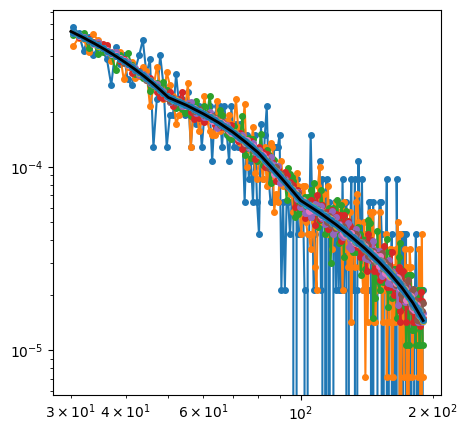

In [14]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'USANS'  # manually selected
best_time_str = str(int(sample4_time_list[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 30
Q_max_range = 200

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 19
polyorder = 3

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'D22'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 192
    print(f"Using nbins = {nbins} for synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'D22' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [15]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['D22'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 5.9642e-06
beta  = 7.5100e-13 ± 1.1283e-14
gamma = 1.8850e-15 ± 2.3828e-17
h_instr = 8.2899e-01
time = 1000.0, h_FD = 1.5835e+01, lambda_opt = 1.1741e+01
time = 3000.0, h_FD = 1.0980e+01, lambda_opt = 9.4252e+00
time = 10000.0, h_FD = 7.3501e+00, lambda_opt = 7.4083e+00
time = 30000.0, h_FD = 5.0963e+00, lambda_opt = 5.9469e+00
time = 100000.0, h_FD = 3.4116e+00, lambda_opt = 4.6743e+00
time = 300000.0, h_FD = 2.3655e+00, lambda_opt = 3.7522e+00
time = 1000000.0, h_FD = 1.5835e+00, lambda_opt = 2.9493e+00
time = 3000000.0, h_FD = 1.0980e+00, lambda_opt = 2.3675e+00
time = 10000000.0, h_FD = 7.3501e-01, lambda_opt = 1.8609e+00
time = 30000000.0, h_FD = 5.0963e-01, lambda_opt = 1.4938e+00
time = 100000000.0, h_FD = 3.4116e-01, lambda_opt = 1.1741e+00


/tmp/ipykernel_120206/232022714.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_USANS32871.json


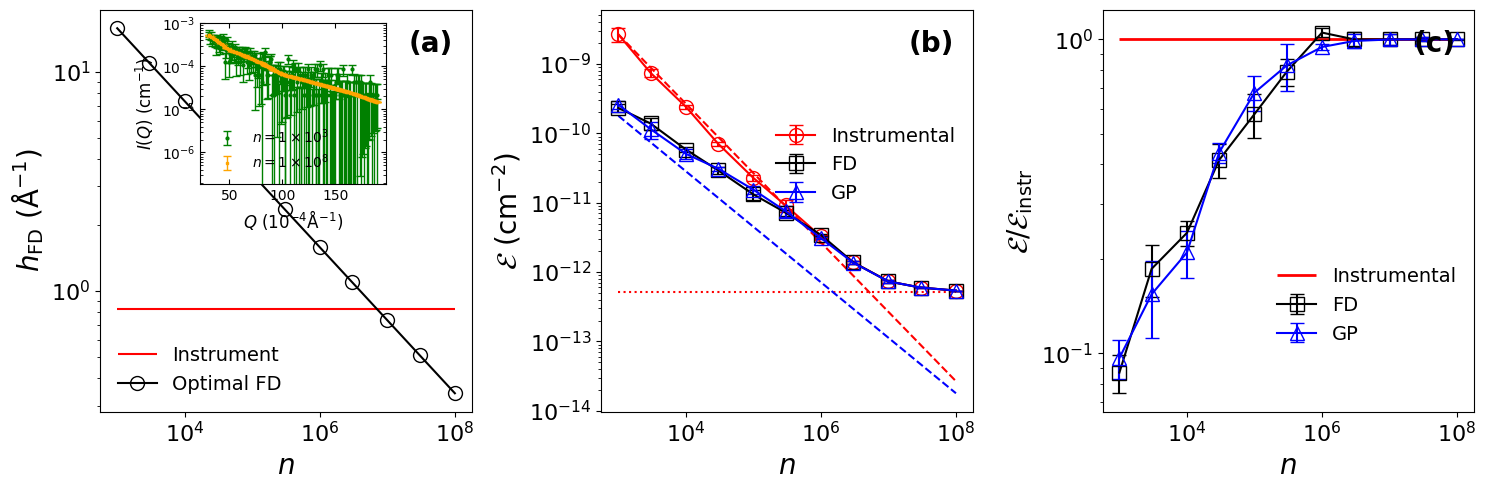

In [16]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_USANS32871.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## USANS2

Index: 0, Filename: UN_DPPC0.2h-HA10_det_1_lb.txt
Index: 1, Filename: UN_h-HA_5_det_1_lb.txt
Index: 2, Filename: UN_DPPC0.2h-HA5_det_1_lb.txt
Index: 3, Filename: UN_DPPC1.2l-HA1.5_det_1_lb.txt
Index: 4, Filename: UN_DPPC0.2l-HA4_det_1_lb.txt
Index: 5, Filename: UN_h-HA_3_det_1_lb.txt
Index: 6, Filename: UN_DPPC0.2l-HA0.33_det_1_lb.txt
Index: 7, Filename: UN_DPPC0.2h-HA1.5_det_1_lb.txt
Index: 8, Filename: UN_l-HA_1.5_det_1_lb.txt
Index: 9, Filename: UN_h-HA_10_det_1_lb.txt
Index: 10, Filename: UN_DPPC1.2h-HA2_det_1_lb.txt
Index: 11, Filename: UN_DPPC_5_det_1_lb.txt
116


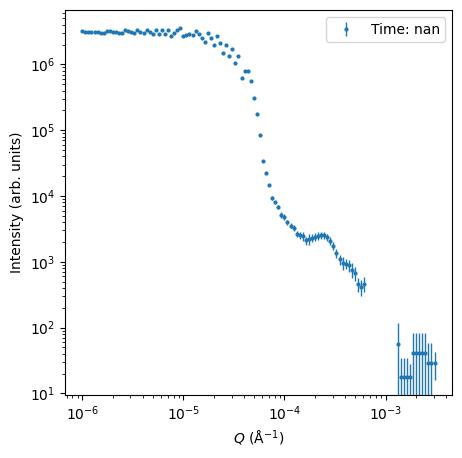

In [17]:
# load data and store into lists
import os
import pandas as pd
import re


file_path = "../data/USANS/28523/"
sample_files = [f for f in os.listdir(file_path)]# if 'UN' in f.lower()]
labels = ["unscaled", "lb.", "lbs"]
filtered_files = [f for f in sample_files if labels[1] in f]
# Prepare lists to store extracted info
measure_times = []
samples = []

for idx, filename in enumerate(filtered_files):
    print(f"Index: {idx}, Filename: {filename}")

for fname in filtered_files:
    # Extract measure time (e.g., 1e4, 3e5, etc.)
    match_time = re.search(r'_(\d+e\d+)_', fname)
    measure_times.append(match_time.group(1) if match_time else None)
    # Extract samples (e.g., Sample1, Sample2, etc.)
    match_samples = re.search(r'(Sample\d+)', fname, re.IGNORECASE)
    samples.append(match_samples.group(1) if match_samples else None)

samples = [
    np.loadtxt(os.path.join(file_path, fname), skiprows=0, delimiter=',', usecols=(0,1,2))
    for fname in filtered_files
]



# display the line profile to be used to produce the counts

data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For USANS, we use bin='USANS' and collimation='-', time is represented by total counts

# Store sample data into the data structure using measurement time as key
for i, arr in enumerate([samples[0]]):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = np.zeros_like(Q)  # USANS files may not have dQ; set to zeros or estimate if available
    total_counts = 'nan'
    # Use bin='USANS', collimation='-', time=str(int(total_counts))
    data['USANS']['-'][total_counts] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # USANS uses '-' for collimation
sorted_time_keys = sorted(data['USANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['USANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

Using best dataset: Bin size = USANS, Time = nan
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
bin width: 1.590022780926013e-06


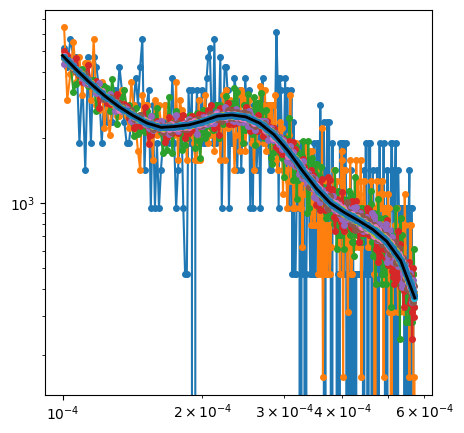

In [18]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'USANS'  # manually selected
best_time_str = 'nan'
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 1e-4
Q_max_range = 6e-4

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 9
polyorder = 3

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'D22'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 297
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'D22' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [19]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['D22'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
h_instr = 1.5847e-06
time = 1000.0, h_FD = 4.1886e-05, lambda_opt = 2.4879e-05
time = 3000.0, h_FD = 2.9042e-05, lambda_opt = 1.9972e-05
time = 10000.0, h_FD = 1.9442e-05, lambda_opt = 1.5698e-05
time = 30000.0, h_FD = 1.3480e-05, lambda_opt = 1.2601e-05
time = 100000.0, h_FD = 9.0242e-06, lambda_opt = 9.9047e-06
time = 300000.0, h_FD = 6.2570e-06, lambda_opt = 7.9509e-06
time = 1000000.0, h_FD = 4.1886e-06, lambda_opt = 6.2494e-06
time = 3000000.0, h_FD = 2.9042e-06, lambda_opt = 5.0167e-06
time = 10000000.0, h_FD = 1.9442e-06, lambda_opt = 3.9431e-06
time = 30000000.0, h_FD = 1.3480e-06, lambda_opt = 3.1653e-06
time = 100000000.0, h_FD = 9.0242e-07, lambda_opt = 2.4879e-06


/tmp/ipykernel_120206/2641776462.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_USANS28523.json


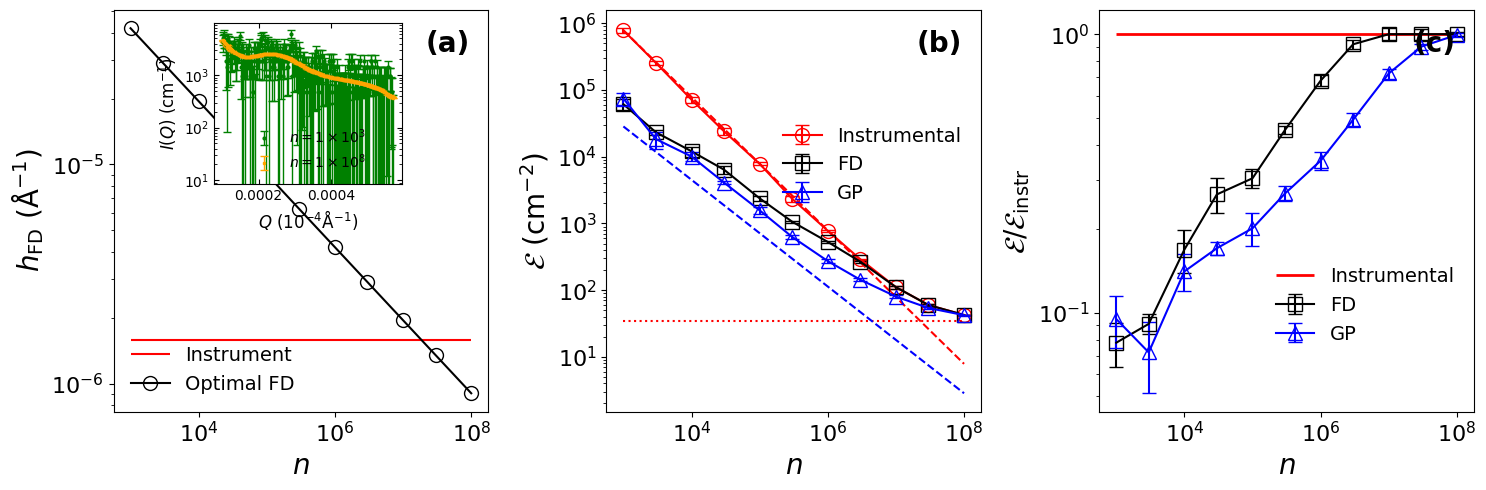

In [20]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['D22'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_USANS28523.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## EQSANS-23463

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
count per sec: 369.75187583957


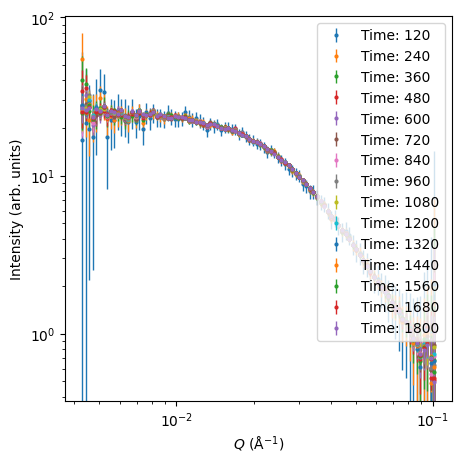

In [52]:
# Define the folder path
folder_path = '../data/EQSANS/output_23463/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[4]) for filename in filenames if filename.endswith('.dat') and '4m12a' in filename and 't4' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f't4_4m12a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))



Using best dataset: Bin size = EQSANS, Time = 1800
Using best dataset: Bin size = EQSANS, Time = 1800
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
bin width: 0.00048592555729166665


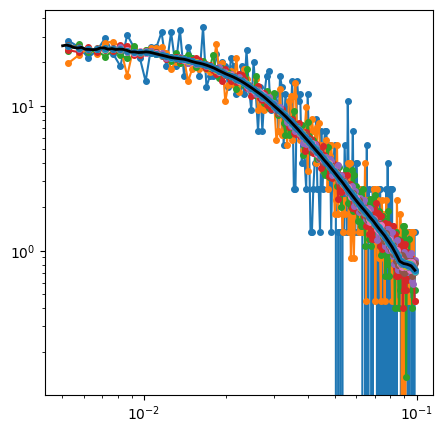

In [53]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 5e-3
Q_max_range = 1e-1

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 7
polyorder = 3

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'EQSANS'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 192
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'EQSANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [54]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['EQSANS'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 1.7675e+01
beta  = 1.9971e+04 ± 1.4392e+03
gamma = 9.9658e+09 ± 7.7582e+08
h_instr = 4.8339e-04
time = 1000.0, h_FD = 7.6203e-03, lambda_opt = 2.6268e-03
time = 3000.0, h_FD = 5.2836e-03, lambda_opt = 2.1087e-03
time = 10000.0, h_FD = 3.5370e-03, lambda_opt = 1.6574e-03
time = 30000.0, h_FD = 2.4524e-03, lambda_opt = 1.3305e-03
time = 100000.0, h_FD = 1.6417e-03, lambda_opt = 1.0458e-03
time = 300000.0, h_FD = 1.1383e-03, lambda_opt = 8.3948e-04
time = 1000000.0, h_FD = 7.6203e-04, lambda_opt = 6.5983e-04
time = 3000000.0, h_FD = 5.2836e-04, lambda_opt = 5.2968e-04
time = 10000000.0, h_FD = 3.5370e-04, lambda_opt = 4.1633e-04
time = 30000000.0, h_FD = 2.4524e-04, lambda_opt = 3.3420e-04
time = 100000000.0, h_FD = 1.6417e-04, lambda_opt = 2.6268e-04


/tmp/ipykernel_1517622/3799453380.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_EQSANS23463.json


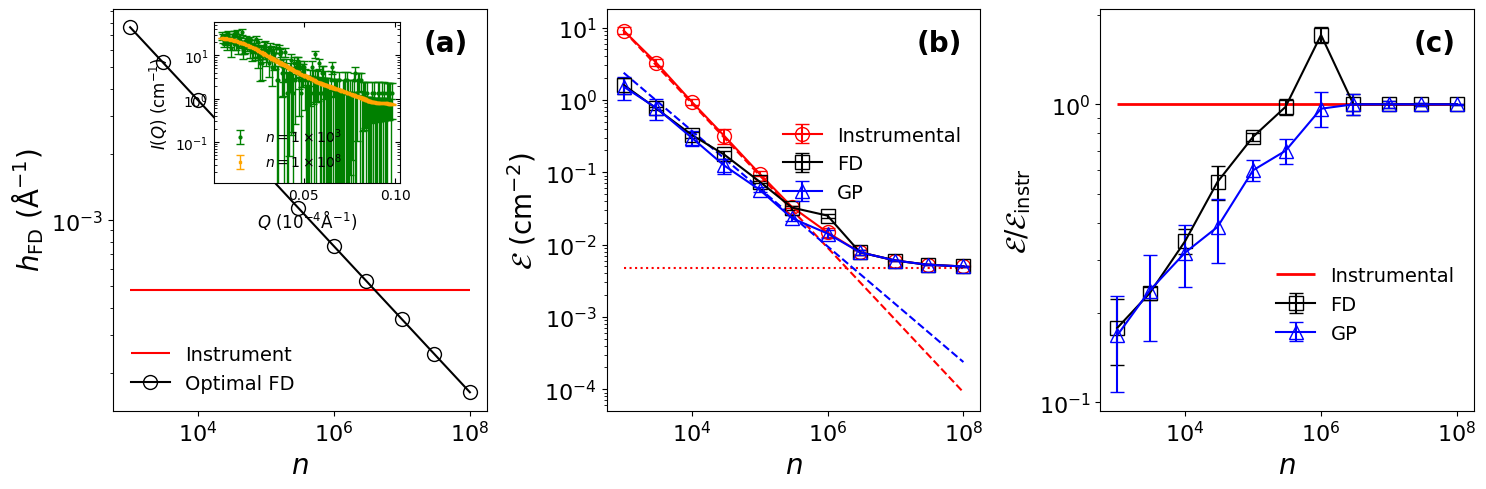

In [55]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_EQSANS23463.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## EQSANS-22170

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
count per sec: 90.68858578358115


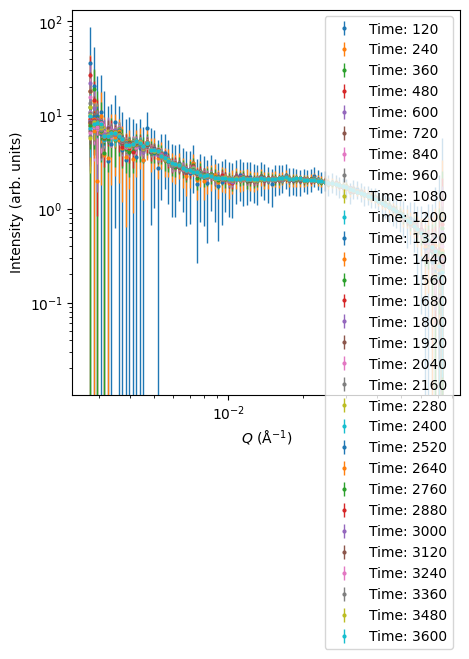

In [56]:
# Define the folder path
folder_path = '../data/EQSANS/output_22170/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '8m8a' in filename and 'S3A' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'S3A_20C_8m8a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))

Using best dataset: Bin size = EQSANS, Time = 3600
Using best dataset: Bin size = EQSANS, Time = 3600
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
bin width: 0.0003597172864583333


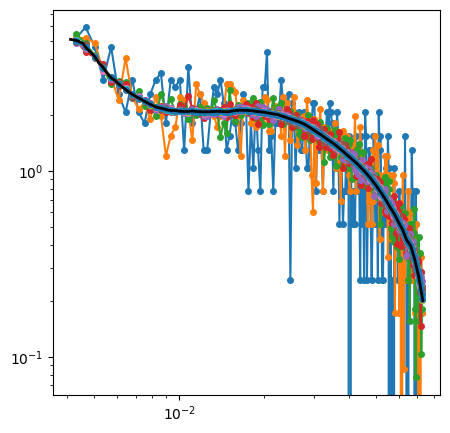

In [62]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 4e-3
Q_max_range = 2e-1

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 8
polyorder = 2

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'EQSANS'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 192
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'EQSANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [63]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['EQSANS'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 2.9437e-01
beta  = 9.1590e+02 ± 2.3736e+01
gamma = 8.7741e+08 ± 5.4579e+07
h_instr = 3.5784e-04
time = 1000.0, h_FD = 5.4367e-03, lambda_opt = 1.8828e-03
time = 3000.0, h_FD = 3.7696e-03, lambda_opt = 1.5114e-03
time = 10000.0, h_FD = 2.5235e-03, lambda_opt = 1.1880e-03
time = 30000.0, h_FD = 1.7497e-03, lambda_opt = 9.5363e-04
time = 100000.0, h_FD = 1.1713e-03, lambda_opt = 7.4956e-04
time = 300000.0, h_FD = 8.1214e-04, lambda_opt = 6.0170e-04
time = 1000000.0, h_FD = 5.4367e-04, lambda_opt = 4.7294e-04
time = 3000000.0, h_FD = 3.7696e-04, lambda_opt = 3.7965e-04
time = 10000000.0, h_FD = 2.5235e-04, lambda_opt = 2.9840e-04
time = 30000000.0, h_FD = 1.7497e-04, lambda_opt = 2.3954e-04
time = 100000000.0, h_FD = 1.1713e-04, lambda_opt = 1.8828e-04


/tmp/ipykernel_1517622/3182696784.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_EQSANS22170.json


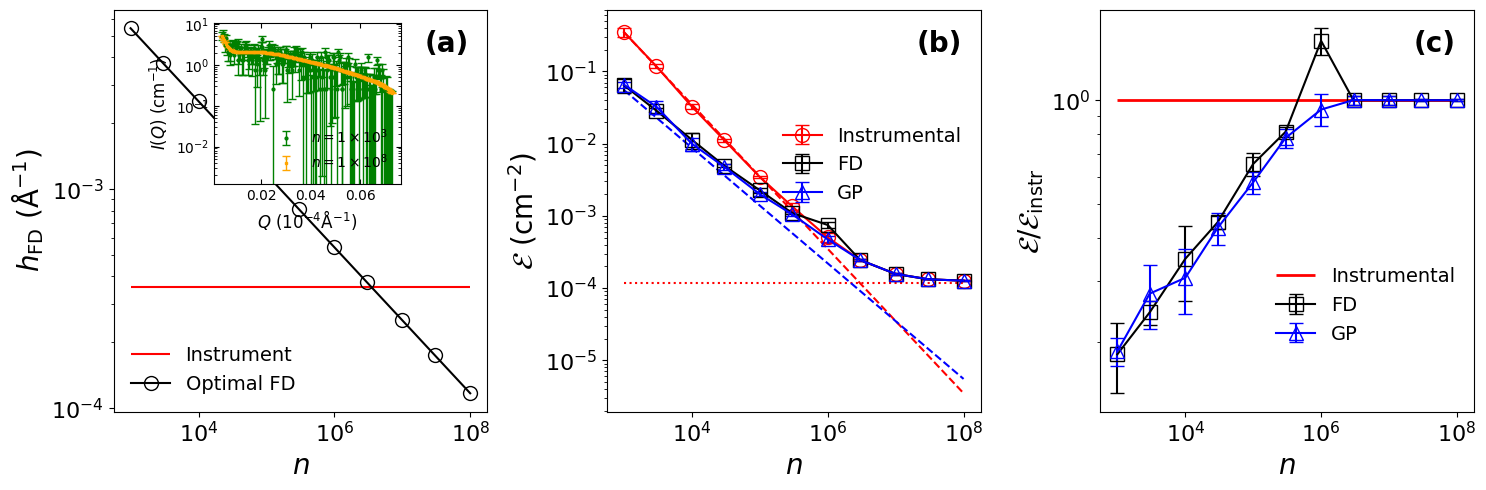

In [64]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_EQSANS22170.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## EQSANS-25953

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
30 3720.0
31 3840.0
32 3960.0
33 4080.0
34 4200.0
35 4320.0
36 4440.0
37 4560.0
38 4680.0
39 4800.0
40 4920.0
41 5040.0
42 5160.0
43 5280.0
44 5400.0
45 5520.0
46 5640.0
47 5760.0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
count per sec: 91.9316895774297


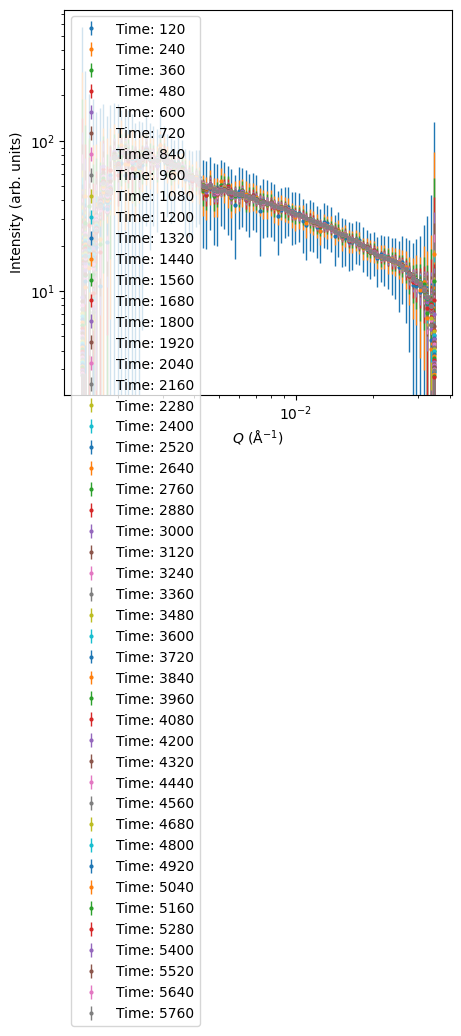

In [67]:
# Define the folder path
folder_path = '../data/EQSANS/output_25953/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[6]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and '9_1mm_25C' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'9_1mm_25C_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))

Using best dataset: Bin size = EQSANS, Time = 5760
Using best dataset: Bin size = EQSANS, Time = 5760
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
bin width: 0.00016839377083333333


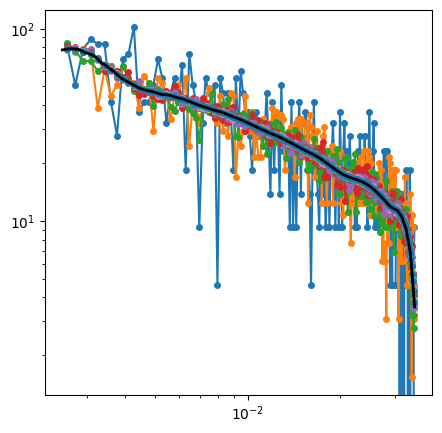

In [69]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 0.0025
Q_max_range = 0.25

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 10
polyorder = 3

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'EQSANS'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 192
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'EQSANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [70]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['EQSANS'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 4.3885e+01
beta  = 1.6388e+06 ± 5.3322e+04
gamma = 1.9612e+12 ± 6.0958e+10
h_instr = 1.6752e-04
time = 1000.0, h_FD = 2.3746e-03, lambda_opt = 1.0955e-03
time = 3000.0, h_FD = 1.6464e-03, lambda_opt = 8.7943e-04
time = 10000.0, h_FD = 1.1022e-03, lambda_opt = 6.9124e-04
time = 30000.0, h_FD = 7.6421e-04, lambda_opt = 5.5488e-04
time = 100000.0, h_FD = 5.1159e-04, lambda_opt = 4.3614e-04
time = 300000.0, h_FD = 3.5471e-04, lambda_opt = 3.5011e-04
time = 1000000.0, h_FD = 2.3746e-04, lambda_opt = 2.7519e-04
time = 3000000.0, h_FD = 1.6464e-04, lambda_opt = 2.2090e-04
time = 10000000.0, h_FD = 1.1022e-04, lambda_opt = 1.7363e-04
time = 30000000.0, h_FD = 7.6421e-05, lambda_opt = 1.3938e-04
time = 100000000.0, h_FD = 5.1159e-05, lambda_opt = 1.0955e-04


/tmp/ipykernel_1517622/2435415552.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_EQSANS25953.json


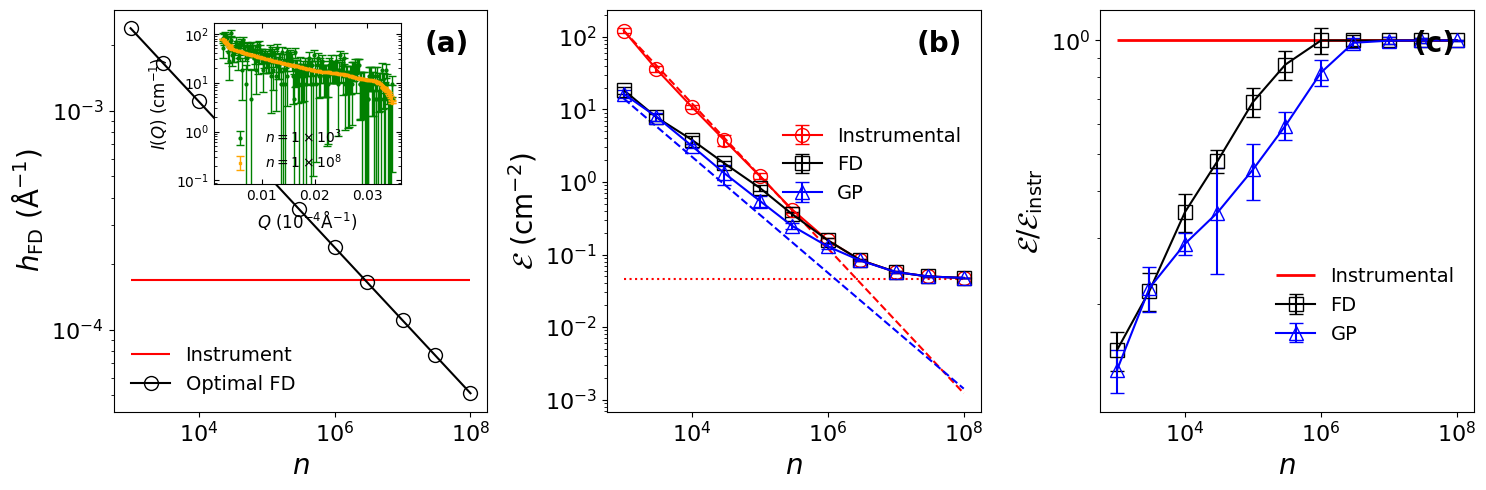

In [71]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_EQSANS25953.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## EQSANS-22386

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
count per sec: 6.16694009242295


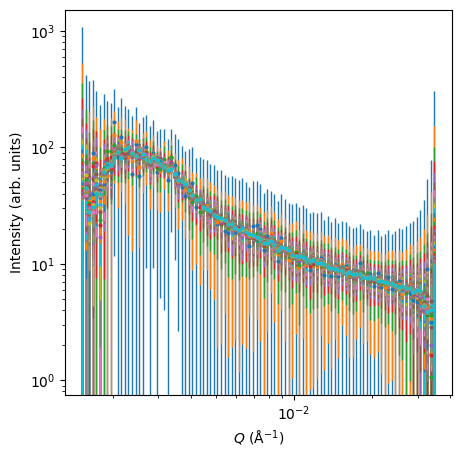

In [83]:
# Define the folder path
folder_path = '../data/EQSANS/output_22386/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '9m15a' in filename and 'CVWLM7' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'CVWLM2_20C_9m15a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])
    
data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For EQSANS, we use bin='EQSANS' and collimation='-', time is represented by total counts

# Store EQSANS data into the data structure using measurement time as key
for i, arr in enumerate(data_list):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = arr[:, 3] if arr.shape[1] > 3 else np.zeros_like(Q)
    total_counts = time_list[i]
    # Use bin='EQSANS', collimation='-', time=str(int(total_counts))
    data['EQSANS']['-'][str(int(total_counts))] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # EQSANS uses '-' for collimation
sorted_time_keys = sorted(data['EQSANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['EQSANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
# ax.legend()

estimated_total_counts = []
for arr in data_list:
    I = arr[:, 1]
    I_err = arr[:, 2]
    N_bin = (I / I_err) ** 2
    total_N = np.sum(N_bin)
    estimated_total_counts.append(total_N)
    # print(f"Estimated total counts: {total_N:.2f}")
    
print('count per sec: {}'.format( np.mean(estimated_total_counts)/np.mean(time_list)))

Using best dataset: Bin size = EQSANS, Time = 3600
Using best dataset: Bin size = EQSANS, Time = 3600
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
Using nbins = 192 for USANS synthetic data generation
bin width: 0.00013909636458333334


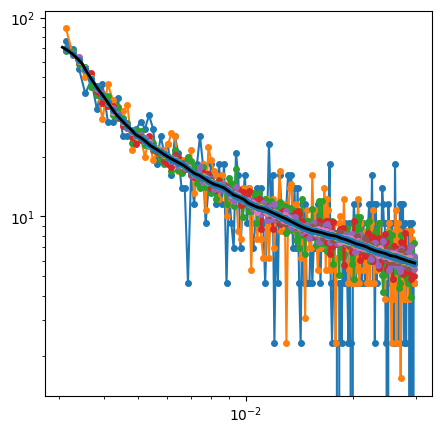

In [88]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'EQSANS'  # manually selected
best_time_str = str(int(sorted_time_keys[-1]))
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 0.003
Q_max_range = 0.03

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 10
polyorder = 3

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'EQSANS'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 192
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'EQSANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [89]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['EQSANS'][fixed_collimation][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 1.0264e+01
beta  = 1.8211e+06 ± 7.7003e+04
gamma = 3.5161e+12 ± 1.4127e+11
h_instr = 1.3837e-04
time = 1000.0, h_FD = 1.4125e-03, lambda_opt = 7.2898e-04
time = 3000.0, h_FD = 9.7934e-04, lambda_opt = 5.8518e-04
time = 10000.0, h_FD = 6.5560e-04, lambda_opt = 4.5995e-04
time = 30000.0, h_FD = 4.5457e-04, lambda_opt = 3.6922e-04
time = 100000.0, h_FD = 3.0430e-04, lambda_opt = 2.9021e-04
time = 300000.0, h_FD = 2.1099e-04, lambda_opt = 2.3296e-04
time = 1000000.0, h_FD = 1.4125e-04, lambda_opt = 1.8311e-04
time = 3000000.0, h_FD = 9.7934e-05, lambda_opt = 1.4699e-04
time = 10000000.0, h_FD = 6.5560e-05, lambda_opt = 1.1554e-04
time = 30000000.0, h_FD = 4.5457e-05, lambda_opt = 9.2745e-05
time = 100000000.0, h_FD = 3.0430e-05, lambda_opt = 7.2898e-05


/tmp/ipykernel_1517622/3660315573.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Data successfully stored in analysis_EQSANS22386.json


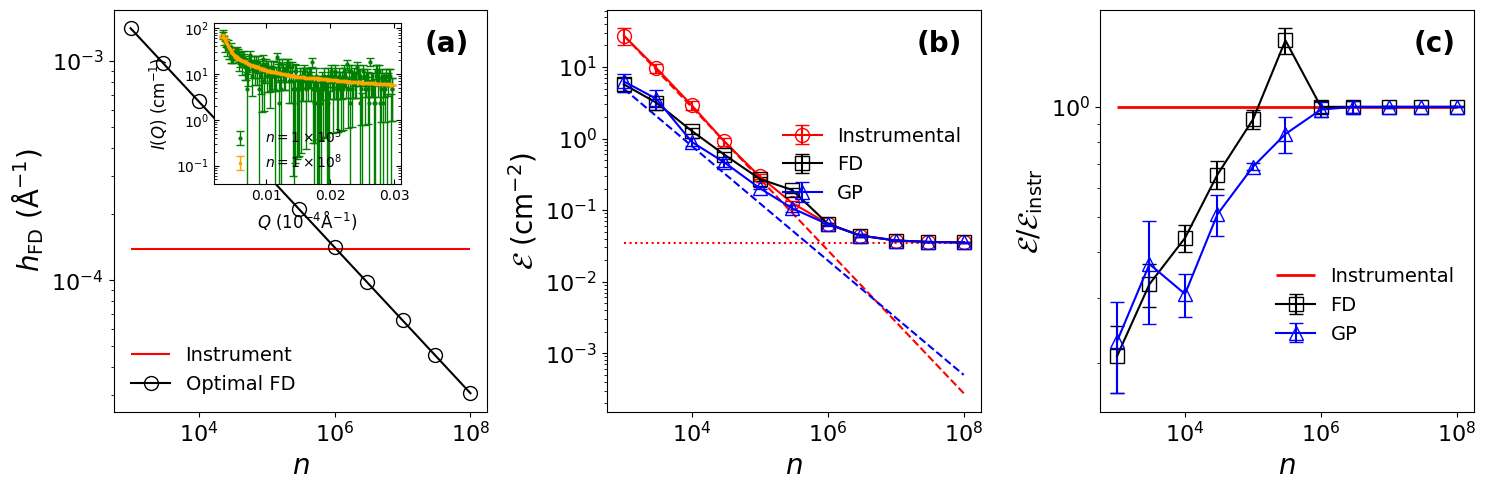

In [90]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['EQSANS'][fixed_collimation][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
output_data = {
    "count_list": count_list.tolist(),
    "synthetic_data_list": [
        {
            bin_size: {
                collimation: {
                    str(time): {
                        "Q": sd.Q.tolist(),
                        "I": sd.I.tolist(),
                        "I_err": sd.I_err.tolist(),
                        "dQ": sd.dQ.tolist(),
                        "total_counts": sd.total_counts
                    }
                    for time, sd in collimation_data.items()
                }
                for collimation, collimation_data in bin_data.items()
            }
            for bin_size, bin_data in synthetic_data.items()
        }
        for synthetic_data in synthetic_data_list
    ],
    "mise_instr_stat": mise_instr_stat.tolist(),
    "mise_FD_stat": mise_FD_stat.tolist(),
    "mise_GP_stat": mise_GP_stat.tolist(),
    "A0_best": A0_best,
    "beta_best": beta_best,
    "beta_best_std": beta_best_std,
    "gamma_best": gamma_best,
    "gamma_best_std": gamma_best_std,
    "pre_factor": pre_factor,
    "h_FD_list": h_FD_list,
    "lambda_opt_list": lambda_opt_list
}

# Save to JSON file
output_file = "analysis_EQSANS22386.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Data successfully stored in {output_file}")

## Visualization

Results from analysis_HANARO.json:
alpha*n = 7.5316e-01
beta  = 1.4099e+06 ± 1.5072e+04
gamma = 2.5534e+12 ± 2.2096e+10
pre_factor = 1.4473e+02
n_cross = 1000000.0, E_cross = 0.0063730988149884185
Results from analysis_D22.json:
alpha*n = 4.0852e-02
beta  = 1.6934e-01 ± 4.5244e-04
gamma = 3.8690e+02 ± 3.8492e+00
pre_factor = 1.5280e-01
n_cross = 10000000.0, E_cross = 4.3450084073082014e-07
Results from analysis_USANS32871.json:
alpha*n = 5.9642e-06
beta  = 7.5100e-13 ± 1.1283e-14
gamma = 1.8850e-15 ± 2.3828e-17
pre_factor = 4.4993e-08
n_cross = 3000000.0, E_cross = 5.161121843017889e-13
Results from analysis_USANS28523.json:
alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
pre_factor = 7.1500e+06
n_cross = 10000000.0, E_cross = 34.313640497185446
Results from analysis_EQSANS23463.json:
alpha*n = 1.7675e+01
beta  = 1.9971e+04 ± 1.4392e+03
gamma = 9.9658e+09 ± 7.7582e+08
pre_factor = 5.9596e+02
n_cross = 3000000.0, E_cross = 0.00466671133763534
Results

/tmp/ipykernel_1517622/3135343082.py:54: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor, yerr=mise_instr_stat[:,1,4]/pre_factor, fmt='o-', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx])
/tmp/ipykernel_1517622/3135343082.py:60: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_instr_stat[:,1,4]/pre_factor/count_list**(-4/5), fmt='o', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx], label=' ')


Results from analysis_HANARO.json:
alpha*n = 7.5316e-01
beta  = 1.4099e+06 ± 1.5072e+04
gamma = 2.5534e+12 ± 2.2096e+10
pre_factor = 1.4473e+02
Results from analysis_D22.json:
alpha*n = 4.0852e-02
beta  = 1.6934e-01 ± 4.5244e-04
gamma = 3.8690e+02 ± 3.8492e+00
pre_factor = 1.5280e-01
Results from analysis_USANS32871.json:
alpha*n = 5.9642e-06
beta  = 7.5100e-13 ± 1.1283e-14
gamma = 1.8850e-15 ± 2.3828e-17
pre_factor = 4.4993e-08
Results from analysis_USANS28523.json:
alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
pre_factor = 7.1500e+06
Results from analysis_EQSANS23463.json:
alpha*n = 1.7675e+01
beta  = 1.9971e+04 ± 1.4392e+03
gamma = 9.9658e+09 ± 7.7582e+08
pre_factor = 5.9596e+02
Results from analysis_EQSANS22170.json:
alpha*n = 2.9437e-01
beta  = 9.1590e+02 ± 2.3736e+01
gamma = 8.7741e+08 ± 5.4579e+07
pre_factor = 1.3848e+01
Results from analysis_EQSANS25953.json:
alpha*n = 4.3885e+01
beta  = 1.6388e+06 ± 5.3322e+04
gamma = 1.9612e+12 ± 6.0958e

/tmp/ipykernel_1517622/3135343082.py:101: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_GP_stat[:,1,4]/pre_factor/count_list**(-4/5), fmt='o', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx], label=label_list[idx])


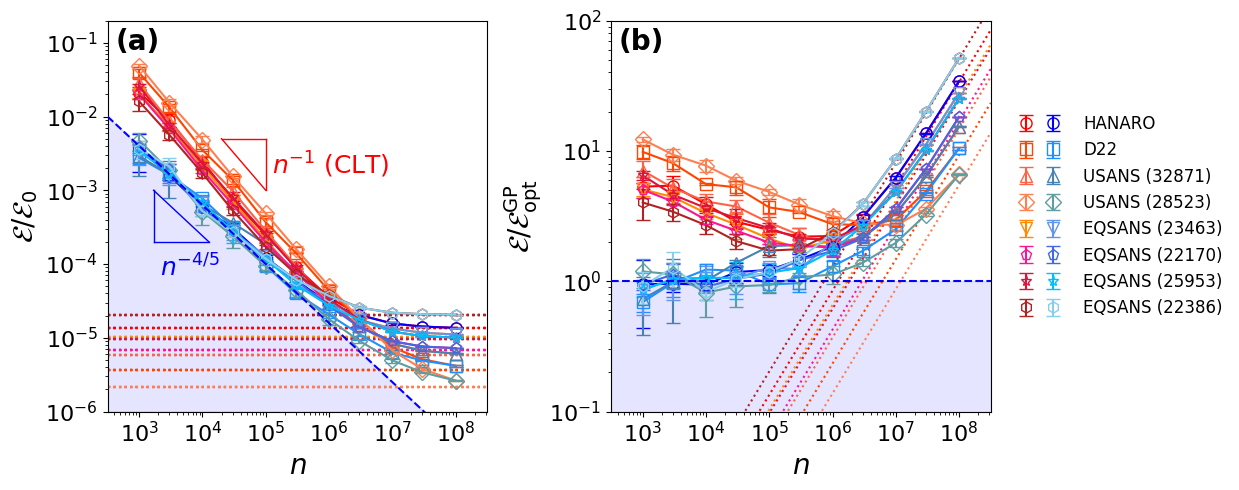

In [162]:
filename_json_list = ["analysis_HANARO.json", "analysis_D22.json", "analysis_USANS32871.json", "analysis_USANS28523.json", 
                      "analysis_EQSANS23463.json", "analysis_EQSANS22170.json", "analysis_EQSANS25953.json", "analysis_EQSANS22386.json"]
label_list = ["HANARO", "D22","USANS (32871)", "USANS (28523)", 
              "EQSANS (23463)", "EQSANS (22170)", "EQSANS (25953)", "EQSANS (22386)"]
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
count_list_fine = np.logspace(2.5, 8.5, 100)
# Define red-ish and blue-ish colors based on CIE 1931 uniform chromaticity
colors_red = ['#FF0000', '#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FF1493', '#DC143C', '#B22222']  # 8 red-ish colors
colors_blue = ['#0000FF', '#1E90FF', '#4682B4', '#5F9EA0', '#6495ED', '#4169E1', '#00BFFF', '#87CEEB']  # 8 blue-ish colors
symbols = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']
alpha = 1

for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    # pre_factor = mise_GP_stat[0,0,4]/count_list[0]**(-4/5)
    # Fit pre_factor using the first three points of mise_GP_stat[:,0,4] in log-log space
    def linear_fit(x, b):
        return -4/5 * x + b

    log_count_list = np.log(count_list[:4])
    log_mise_GP = np.log(mise_GP_stat[:4, 0, 4])

    popt, _ = curve_fit(linear_fit, log_count_list, log_mise_GP)
    pre_factor = np.exp(popt[0])  # Convert intercept back to linear space
    
    # Calculate the intersection point
    E_cross = (mise_GP_stat[:, 0, 2] + mise_GP_stat[:, 0, 3])
    n_cross = count_list[np.argmin(np.abs(pre_factor * count_list**(-4/5) - E_cross))]
    print(f"n_cross = {n_cross}, E_cross = {E_cross[np.argmin(np.abs(pre_factor * count_list**(-4/5) - E_cross))]}")
    
    ax1.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor, yerr=mise_instr_stat[:,1,4]/pre_factor, fmt='o-', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx])
    ax1.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor, yerr=mise_GP_stat[:,1,4]/pre_factor, linestyle='-', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx])
    # ax1.plot(count_list, count_list**(-4/5), '--', label=filename_json.replace('analysis_','').replace('.json','')+' theory', color='k', zorder=-20)
    ax1.hlines((mise_GP_stat[:,0,2]+mise_GP_stat[:,0,3])/pre_factor, xmin=count_list_fine[0], xmax=count_list_fine[-1], colors=cr, linestyles=':', zorder=-10, alpha=alpha)
    # ax1.plot(count_list_fine, count_list_fine**(-1) + (mise_GP_stat[0,0,2]+mise_GP_stat[0,0,3])/pre_factor, '--', label='theory', color=cb, zorder=-20)
    
    ax2.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_instr_stat[:,1,4]/pre_factor/count_list**(-4/5), fmt='o', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx], label=' ')
    
    ax2.plot(count_list, mise_instr_stat[:,0,4]/pre_factor/count_list**(-4/5), linestyle='-', color=cr, alpha=alpha)
    ax2.plot(count_list, mise_GP_stat[:,0,4]/pre_factor/count_list**(-4/5), linestyle='-', color=cb, alpha=alpha)
    # ax2.plot(count_list, count_list**(-4/5)/count_list**(-4/5), '--', label=filename_json.replace('analysis_','').replace('.json','')+' theory', color='k', zorder=-20)
    ax2.plot(count_list_fine, (mise_instr_stat[0,0,2]+mise_instr_stat[0,0,3])/pre_factor/count_list_fine**(-4/5), ':', color=cr, zorder=-10, alpha=alpha)
    
for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    # pre_factor = mise_GP_stat[0,0,4]/count_list[0]**(-4/5)
    # Fit pre_factor using the first three points of mise_GP_stat[:,0,4] in log-log space
    def linear_fit(x, b):
        return -4/5 * x + b

    log_count_list = np.log(count_list[:4])
    log_mise_GP = np.log(mise_GP_stat[:4, 0, 4])

    popt, _ = curve_fit(linear_fit, log_count_list, log_mise_GP)
    pre_factor = np.exp(popt[0])  # Convert intercept back to linear space
    
    ax2.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_GP_stat[:,1,4]/pre_factor/count_list**(-4/5), fmt='o', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx], label=label_list[idx])

ax1.plot(count_list_fine, count_list_fine**(-4/5), '--', color='b', zorder=20)
ax1.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-6, count_list_fine**(-4/5), color='b', alpha=0.1, zorder=-21)
ax2.plot(count_list_fine, count_list_fine**(-4/5)/count_list_fine**(-4/5), '--', color='b', zorder=20)
ax2.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-1, count_list_fine**(-4/5)/count_list_fine**(-4/5), color='b', alpha=0.1, zorder=-21)
    
ax1.set_xlabel(r'$n$', fontsize=20)
ax1.set_ylabel(r'$\mathcal{E} /\mathcal{E}_0$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax1.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax1.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax1.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax1.set_ylim(1e-6, 2e-1)
ax1.set_xlim(count_list_fine[0], count_list_fine[-1])
# ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
ax1.text(0.02, 0.98, "(a)", transform=ax1.transAxes, ha='left', va='top', fontsize=20, fontweight='bold')

y_triangle = np.array([5e-3, 1e-3])
x_triangle = 1e2 / y_triangle 
ax1.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='r', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax1.text(x_triangle[1] * 1.25, np.sqrt(y_triangle[0] * y_triangle[1]), r"$n^{-1}$ (CLT)", fontsize=18, va='center', ha='left', color='r')

y_triangle = np.array([2e-4, 1e-3])
x_triangle = 0.3 / y_triangle**(5/4) 
ax1.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='b', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
ax1.text(x_triangle[1] * 1.25, np.sqrt(y_triangle[0] * y_triangle[1])/5 , r"$n^{-4/5}$", fontsize=18, va='center', ha='left', color='b')

ax2.set_xlabel(r'$n$', fontsize=20)
ax2.set_ylabel(r'$\mathcal{E}/\mathcal{E}^\mathrm{GP}_\mathrm{opt}$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax2.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax2.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax2.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax2.set_ylim(1e-1, 1e2)
ax2.set_xlim(count_list_fine[0], count_list_fine[-1])
ax2.text(0.02, 0.98, "(b)", transform=ax2.transAxes, ha='left', va='top', fontsize=20, fontweight='bold')

ax2.legend(fontsize=12, frameon=False, loc='right', bbox_to_anchor=(1.65, 0.5), ncol=2, columnspacing=-1.5)

plt.tight_layout()

Results from analysis_HANARO.json:
alpha*n = 7.5316e-01
beta  = 1.4099e+06 ± 1.5072e+04
gamma = 2.5534e+12 ± 2.2096e+10
pre_factor = 1.4473e+02
Results from analysis_D22.json:
alpha*n = 4.0852e-02
beta  = 1.6934e-01 ± 4.5244e-04
gamma = 3.8690e+02 ± 3.8492e+00
pre_factor = 1.5280e-01
Results from analysis_USANS32871.json:
alpha*n = 5.9642e-06
beta  = 7.5100e-13 ± 1.1283e-14
gamma = 1.8850e-15 ± 2.3828e-17
pre_factor = 4.4993e-08
Results from analysis_USANS28523.json:
alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
pre_factor = 7.1500e+06
Results from analysis_EQSANS23463.json:
alpha*n = 1.7675e+01
beta  = 1.9971e+04 ± 1.4392e+03
gamma = 9.9658e+09 ± 7.7582e+08
pre_factor = 5.9596e+02
Results from analysis_EQSANS22170.json:
alpha*n = 2.9437e-01
beta  = 9.1590e+02 ± 2.3736e+01
gamma = 8.7741e+08 ± 5.4579e+07
pre_factor = 1.3848e+01
Results from analysis_EQSANS25953.json:
alpha*n = 4.3885e+01
beta  = 1.6388e+06 ± 5.3322e+04
gamma = 1.9612e+12 ± 6.0958e

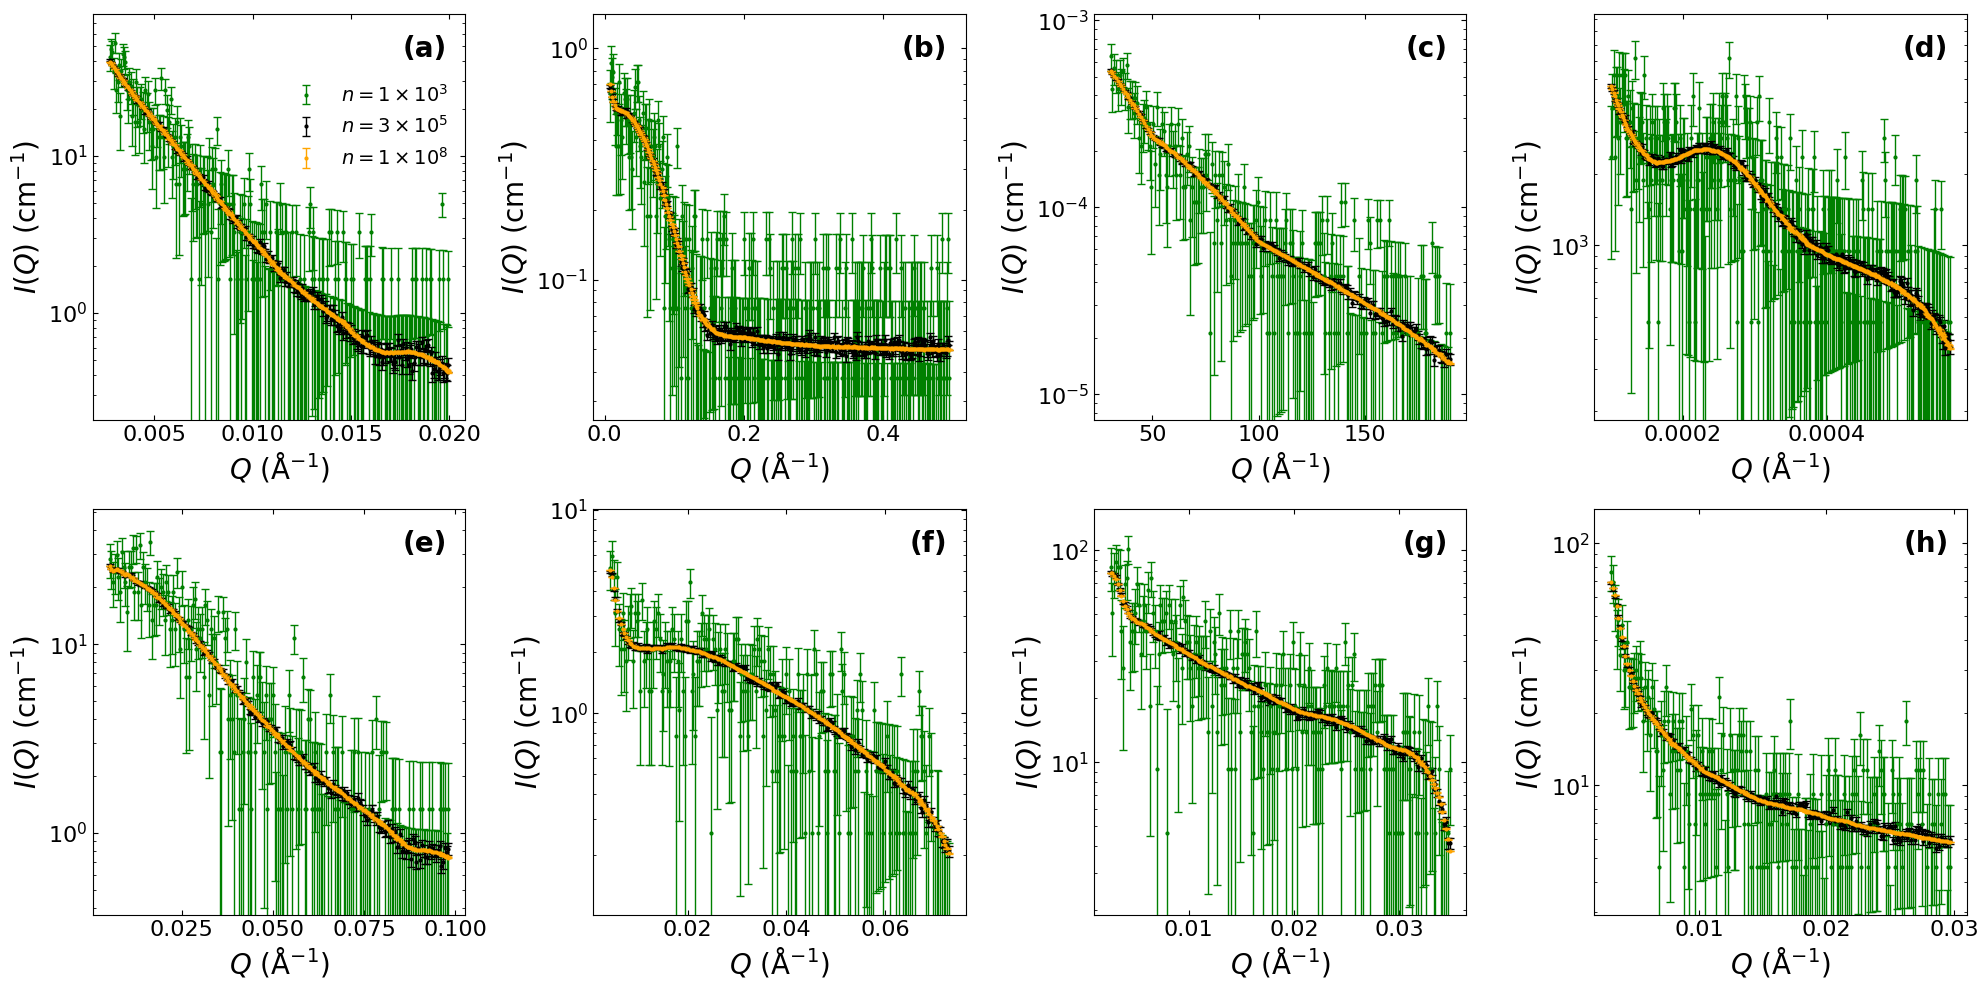

In [231]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter


filename_json_list = ["analysis_HANARO.json", "analysis_D22.json", "analysis_USANS32871.json", "analysis_USANS28523.json", 
                      "analysis_EQSANS23463.json", "analysis_EQSANS22170.json", "analysis_EQSANS25953.json", "analysis_EQSANS22386.json"]
label_list = ["HANARO", "D22","USANS (32871)", "USANS (28523)", 
              "EQSANS (23463)", "EQSANS (22170)", "EQSANS (25953)", "EQSANS (22386)"]
fig = plt.figure(figsize=(20, 10))
count_list_fine = np.logspace(2.5, 8.5, 100)
# Define red-ish and blue-ish colors based on CIE 1931 uniform chromaticity
colors_red = ['#FF0000', '#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FF1493', '#DC143C', '#B22222']  # 8 red-ish colors
colors_blue = ['#0000FF', '#1E90FF', '#4682B4', '#5F9EA0', '#6495ED', '#4169E1', '#00BFFF', '#87CEEB']  # 8 blue-ish colors
symbols = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']
alpha = 1
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

# Define a continuous color scale over black-green-orange-white

colors = ["green", "black", "orange"]
cmap = LinearSegmentedColormap.from_list("black-green-orange", colors)
# cmap = plt.cm.rainbow

for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    sd_syn = loaded_data["synthetic_data_list"][0]
    data = sd_syn[next(iter(sd_syn))][next(iter(sd_syn[next(iter(sd_syn))]))]
    
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    ax = fig.add_subplot(2, 4, idx + 1)
    
    for i_count, count in enumerate(count_list[[0,5,10]]):
        sd_syn_time = data[str(count)]
        ax.errorbar(sd_syn_time['Q'], sd_syn_time['I'], yerr=sd_syn_time['I_err'], 
                label=f'$n={np.ceil(count/10**(np.floor(np.log10(count)))).astype(int)}\\times 10^{np.floor(np.log10(count)).astype(int)}$', 
                fmt='o', markersize=2, elinewidth=1, capsize=3, 
                color=colors[i_count])
    ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_xlim(2e-3, 2e-2)
    # ax.set_ylim(1e-1, 1e2)
    ax.set_ylim(np.min(sd_syn_time['I'])/2, np.max(sd_syn_time['I'])*2)
    # ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
    # ax.set_xticklabels(['0', '2', '4', '6'])
    ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
    ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=20)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    # ax.set_xlim(10**np.floor(np.log10(np.min(sd_syn_time['Q']))), 10**np.ceil(np.log10(np.max(sd_syn_time['Q']))))
    if idx==0:
        ax.legend(fontsize=14, frameon=False, loc=(0.5,0.6))

    ax.text(0.95, 0.95, panel_labels[idx], transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')
    
plt.tight_layout()